In [1]:
# Import necessary packages
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.layers import Dense
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.metrics import binary_accuracy
from keras.preprocessing import image

from keras.models import Model

from keras.optimizers import Adam
from keras.optimizers import AdamW
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Import Densenet from Keras
from keras.applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")
sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

2025-05-06 03:13:44.509869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746501224.750510      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746501224.821470      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset CSV file
csv_file_path = '/kaggle/input/cleaned-file/cleaned_file.csv'  # Adjust the path if necessary
df = pd.read_csv(csv_file_path)

# Split dataset into 70% training, 15% validation, and 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)  # 30% for validation + test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp_df evenly

# Print the number of rows in each split to verify
print(f"Train DataFrame: {train_df.shape[0]} rows")
print(f"Validation DataFrame: {val_df.shape[0]} rows")
print(f"Test DataFrame: {test_df.shape[0]} rows")



# Optionally, inspect the first few rows of each split
print("\nTrain DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame: 31741 rows
Validation DataFrame: 6802 rows
Test DataFrame: 6802 rows

Train DataFrame:
            Image Index  Atelectasis  Cardiomegaly  Consolidation  Edema  \
25952  00020725_017.png            0             0              0      0   
37089  COVID19(194).png            0             0              0      0   
24172  00013924_000.png            0             0              0      0   
6754   00001437_034.png            0             0              0      0   
37227  COVID19(318).png            0             0              0      0   

       Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  Nodule  \
25952         0          0         0       0             0     0       0   
37089         0          0         0       0             0     0       0   
24172         0          0         0       0             0     0       1   
6754          0          1         0       0             1     0       0   
37227         0          0         0       0             0 

In [3]:
#For cheaking data leakage
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0 
    
    ### END CODE HERE ###
    
    return leakage

In [4]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'Image Index')))
print("leakage between valid and test: {}".format(check_for_leakage(val_df, test_df, 'Image Index')))

leakage between train and test: False
leakage between valid and test: False


In [5]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image Index', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumothorax', 'COVID-19', 'Tuberculosis', 'Viral Pneumonia', 'Bacterial Pneumonia']


In [6]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening','Pneumothorax','COVID-19','Tuberculosis','Viral Pneumonia','Bacterial Pneumonia']

In [7]:
import pandas as pd

# Load the CSV file
csv_path = '/kaggle/input/cleaned-file/cleaned_file.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_path)

# Drop the 'Image Index' column to focus on the disease labels
disease_labels = df.drop(columns=['Image Index'])

# Calculate the sample count for each disease
disease_counts = disease_labels.sum()

# Print the sample count for each disease
print("Sample count for each disease:")
print(disease_counts)

Sample count for each disease:
Atelectasis            6724
Cardiomegaly           2115
Consolidation          3432
Edema                  1628
Effusion               6202
Emphysema              2086
Fibrosis               1406
Hernia                  194
Infiltration           9637
Mass                   4709
Nodule                 5196
Pleural_Thickening     2646
Pneumothorax           4332
COVID-19               2279
Tuberculosis           3499
Viral Pneumonia        1493
Bacterial Pneumonia    2780
dtype: int64


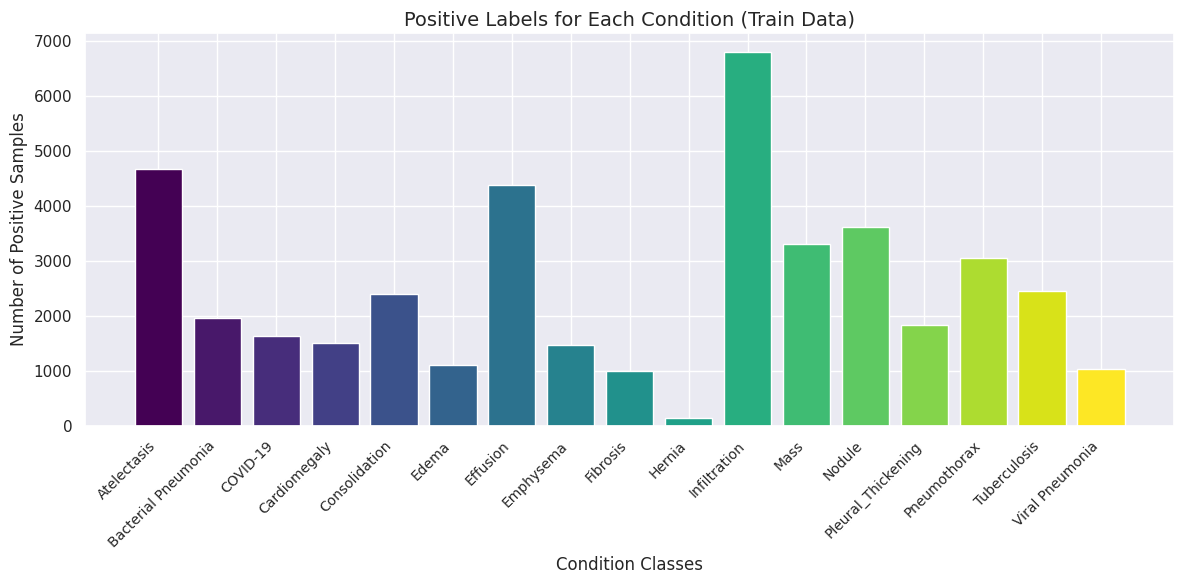

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Exclude 'Image Index' from the columns
columns = train_df.columns.difference(['Image Index'])

# Count positive samples for each condition
positive_counts = [train_df[column].sum() for column in columns]

# Convert columns to strings (ensuring all labels are valid)
columns = [str(col) for col in columns]

# Generate a color for each class using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(columns)))

# Create the bar graph
plt.figure(figsize=(12, 6))
plt.bar(columns, positive_counts, color=colors)
plt.xlabel('Condition Classes', fontsize=12)
plt.ylabel('Number of Positive Samples', fontsize=12)
plt.title('Positive Labels for Each Condition (Train Data)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

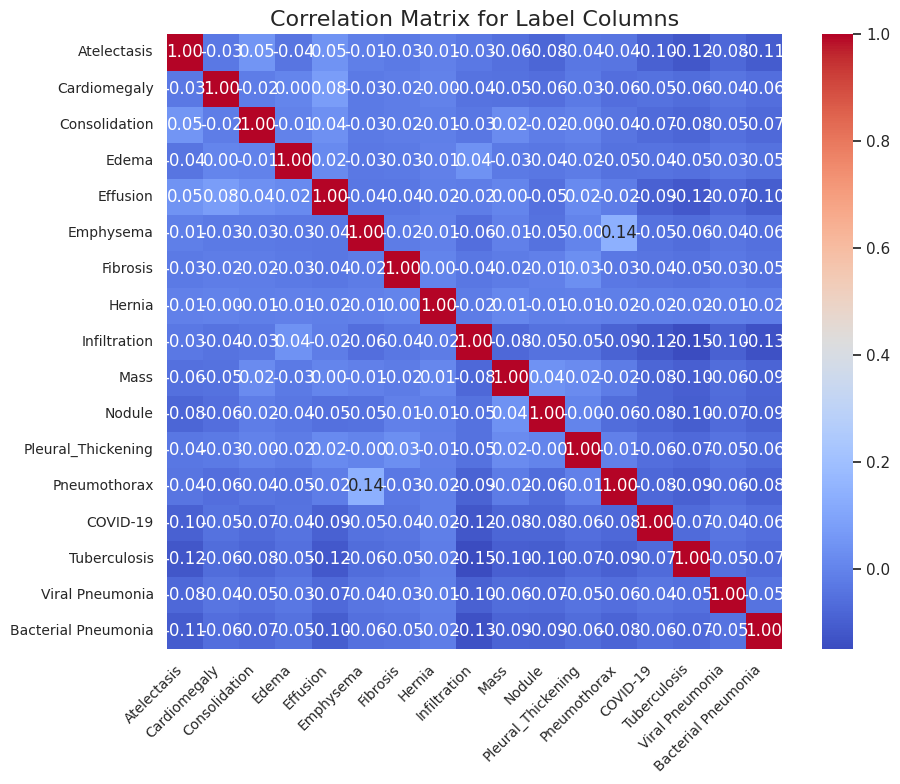

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame
# Calculate the correlation matrix for the label columns
correlation_matrix = train_df[labels].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix for Label Columns', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

Display Random Images


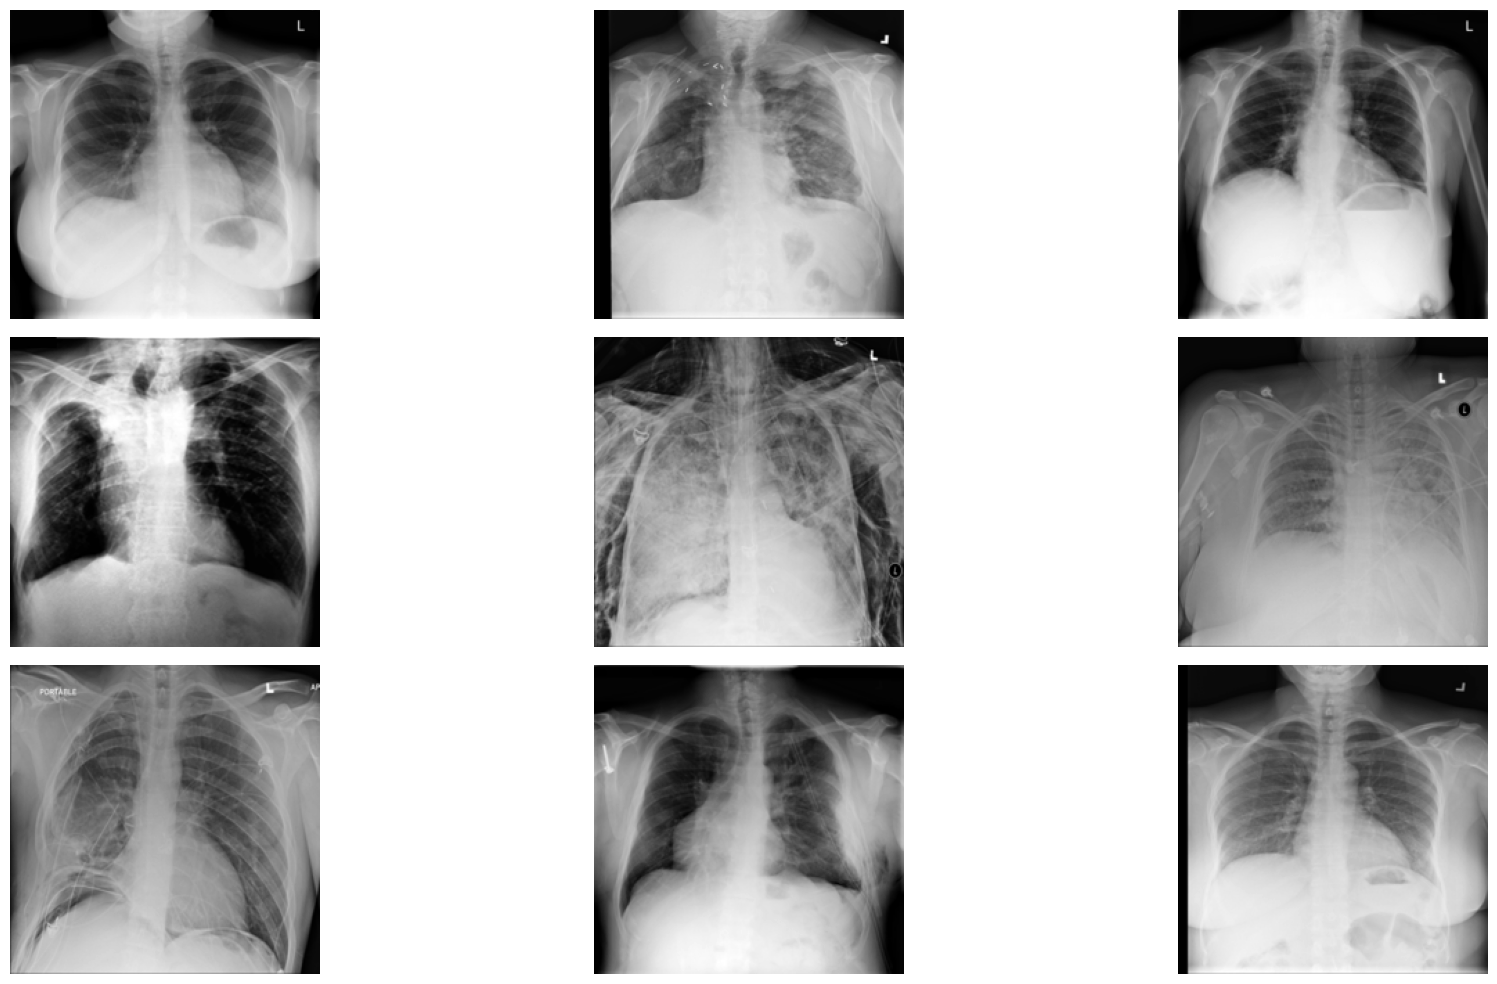

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Extract numpy values from the Image Index column in the data frame
images = train_df['Image Index'].values

# Extract 9 random images
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image directory
img_dir = '/kaggle/input/images/cleanimagefolder'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20, 10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img_path = os.path.join(img_dir, random_images[i])
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.show()


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel
The maximum pixel value is 0.9216 and the minimum is 0.0000
The mean value of the pixels is 0.4852 and the standard deviation is 0.2489


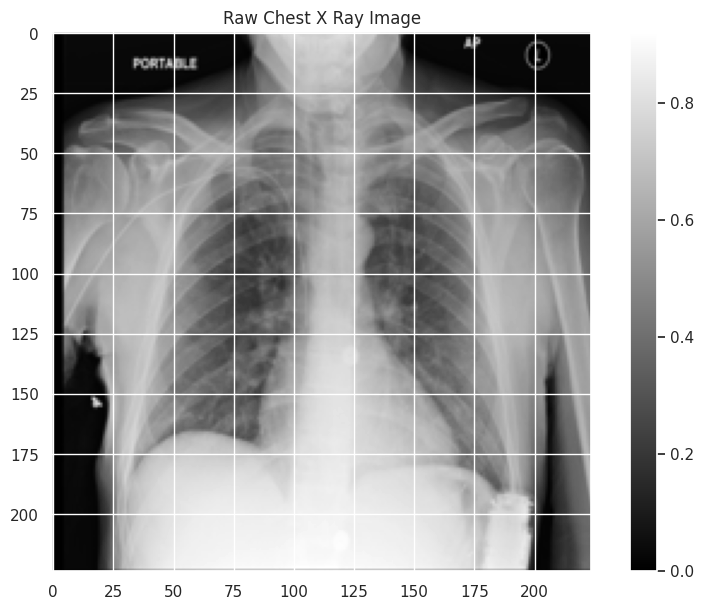

In [11]:
#train_df = train_df.reset_index(drop=True)

# Get the first image that was listed in the train_df dataframe
sample_img = train_df.iloc[0]['Image Index']
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

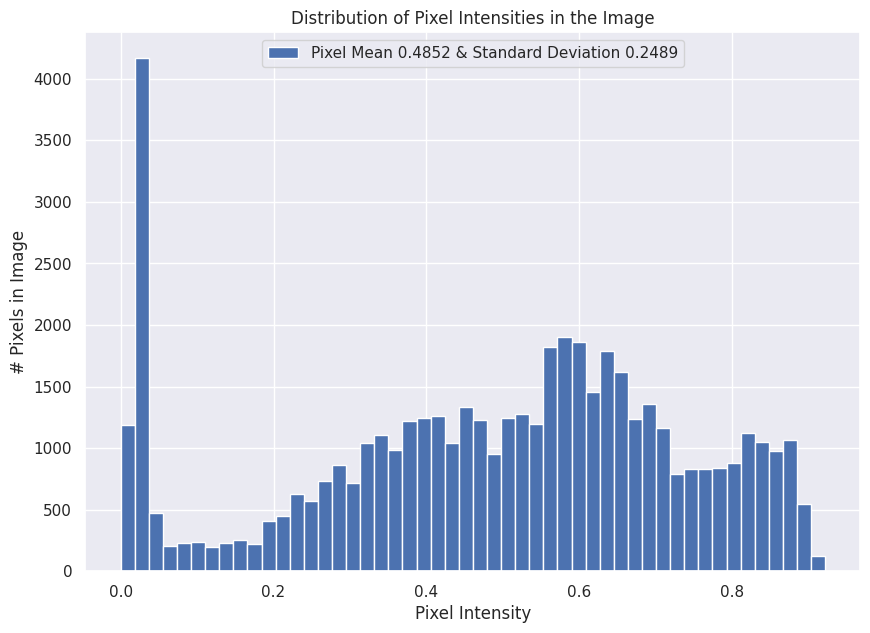

In [12]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

In [13]:
import numpy as np
# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(2, 2))
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Apply CLAHE to the image
    #claheimage = clahe.apply(img)
    img = img / 255.0
    img = (img - mean) / std
    return img


In [14]:
# Update the train generator with the high batch size
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"
train_generator = ImageDataGenerator(
    samplewise_center=False, 
    samplewise_std_normalization=False, 
    horizontal_flip=True, 
    height_shift_range=0.1, 
    width_shift_range=0.05,
    rotation_range=5, 
    shear_range=0.1,
    zoom_range=0.05,    
    preprocessing_function=preprocess_image
).flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,  # Using the correct image directory
    x_col='Image Index',  # Correcting x_col to 'id' as per your dataset
    y_col=labels,
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',  # Load images in RGB color mode
    class_mode='raw',  # Multi-output, raw labels (binary vector for each image)
    batch_size=64,  # Use a larger batch size for faster processing
    shuffle=False  # Ensure data order is consistent
)

Found 31714 validated image filenames.


In [15]:
# Define the directory where images are stored
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"

# Updated validation generator
val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image  # Custom preprocessing function
).flow_from_dataframe(
    dataframe=val_df,  # Use the validation DataFrame
    directory=IMAGE_DIR,  # Use the image directory for validation images
    x_col='Image Index',  # Correcting x_col to 'id' as per your dataset
    y_col=labels,
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',  # Load images in RGB color mode
    class_mode='raw',  # Multi-output, raw labels (binary vector for each image)
    batch_size=64  # Batch size
)

Found 6800 validated image filenames.


The dimensions of the image are 224 pixels width and 224 pixels height
The maximum pixel value is 2.2913 and the minimum is -2.1022
The mean value of the pixels is 0.2926 and the standard deviation is 1.0047


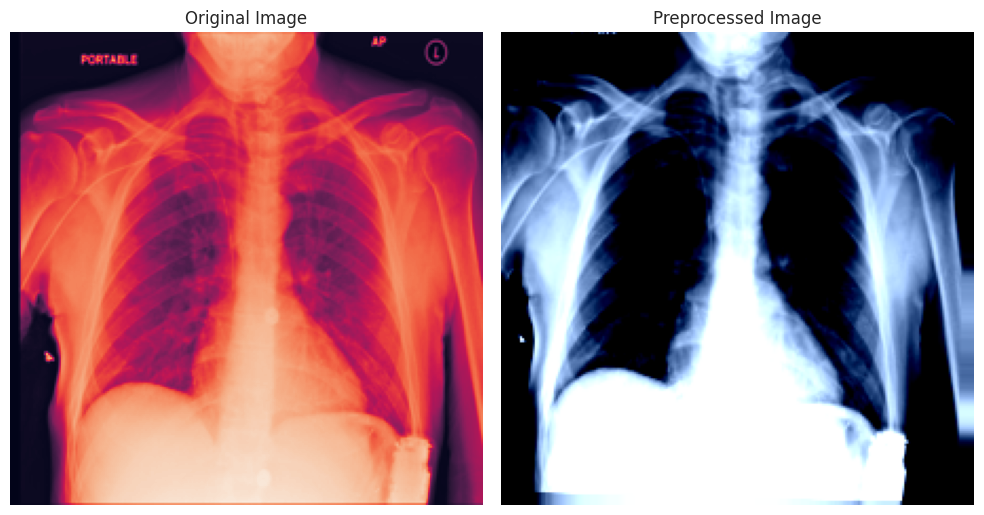

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming the train_generator has been defined earlier as shown

# Get a single batch of images and labels
sample_batch, _ = next(train_generator)  # _ is the corresponding labels

# Choose a random image from the batch
generated_image = sample_batch[0]

# Print image information
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[0]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

# Plot the original and preprocessed images
#plt.figure(figsize=(12, 6))

# Display the original (before preprocessing) image
plt.subplot(1, 2, 1)
# Read the raw image using the path from 'train_df' to show the original
image_path = os.path.join(IMAGE_DIR, train_df['Image Index'].iloc[0])
original_img = plt.imread(image_path)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Display the preprocessed image from the batch
plt.subplot(1, 2, 2)
# Clip the preprocessed image values to the valid range [0, 1] for visualization
plt.imshow(np.clip(generated_image, 0, 1))  # Preprocessed image
plt.title("Preprocessed Image")
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

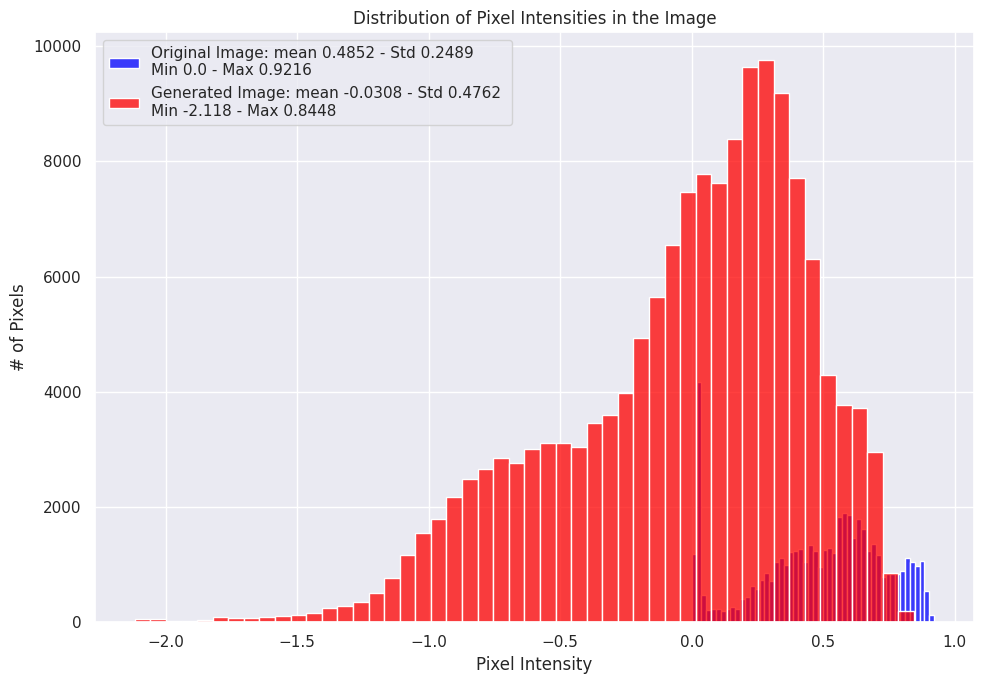

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get a single batch of images and labels
sample_batch, _ = next(train_generator)  # _ is the corresponding labels

# Choose a random image from the batch (we'll use the first image in the batch)
generated_image = sample_batch[0]

# Read the raw image using the path from 'train_df' to show the original
image_path = os.path.join(IMAGE_DIR, train_df['Image Index'].iloc[0])
raw_image = plt.imread(image_path)

# Plot histograms of pixel distributions
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for the original image
sns.histplot(raw_image.ravel(), 
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Std {np.std(raw_image):.4f} \n'
             f'Min {np.min(raw_image):.4} - Max {np.max(raw_image):.4}', 
             color='blue', 
             kde=False, bins=50)

# Plot histogram for the generated (preprocessed) image
sns.histplot(generated_image.ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image):.4f} - Std {np.std(generated_image):.4f} \n'
             f'Min {np.min(generated_image):.4} - Max {np.max(generated_image):.4}', 
             color='red', 
             kde=False, bins=50)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# of Pixels')

# Show the plot
plt.tight_layout()
plt.show()

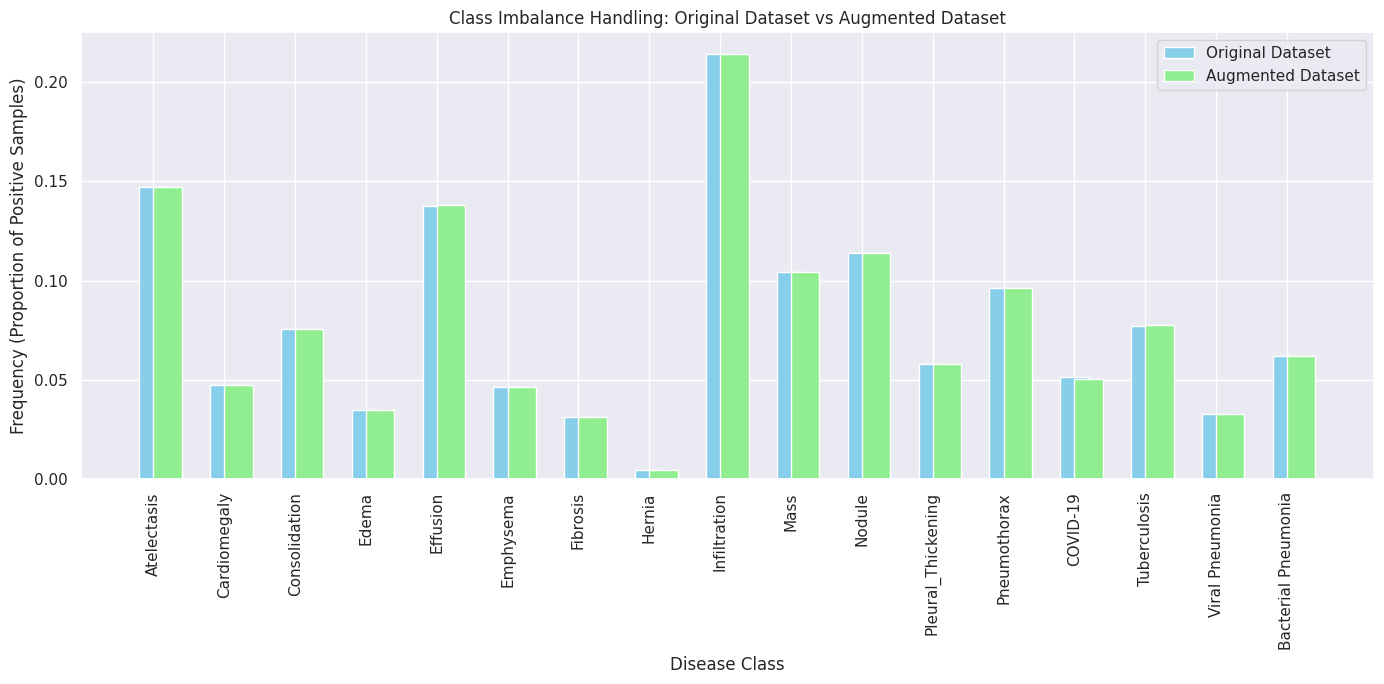

In [18]:
import numpy as np
import matplotlib.pyplot as plt


original_frequencies = np.mean(train_df[labels].values, axis=0)

# Calculate the frequencies of the classes from the train_generator
train_generator_frequencies = np.mean(train_generator.labels[:, :len(labels)], axis=0)

# Plotting comparison for class imbalance before and after augmentation
plt.figure(figsize=(14, 7))

# Plot original dataset class frequencies
plt.bar(labels, original_frequencies, width=0.4, label='Original Dataset', align='center', color='skyblue')

# Plot train_generator class frequencies
plt.bar(labels, train_generator_frequencies, width=0.4, label='Augmented Dataset', align='edge', color='lightgreen')

# Add labels and title
plt.title("Class Imbalance Handling: Original Dataset vs Augmented Dataset")
plt.xlabel("Disease Class")
plt.ylabel("Frequency (Proportion of Positive Samples)")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
# from keras.optimizers import Adamax
# from tensorflow.keras.metrics import AUC

# def build_model(input_shape=(224, 224, 3), num_classes=len(labels)):
#     inputs = Input(shape=input_shape)

#     # Block 1
#     x = Conv2D(32, (3, 3), padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Block 2
#     x = Conv2D(64, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Block 3
#     x = Conv2D(128, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Block 4
#     x = Conv2D(256, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((2, 2))(x)

#     # Global Average Pooling + Dropout
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x)

#     # Dense output for multi-label classification
#     outputs = Dense(num_classes, activation='sigmoid')(x)

#     model = Model(inputs=inputs, outputs=outputs)

#     # Compile
#     optimizer = Adamax(learning_rate=1e-3)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy', AUC(name='auc')])

#     print("Compiled custom CNN model")
#     return model

In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, AveragePooling2D, GlobalAveragePooling2D, Dropout, Dense
from keras.optimizers import Adamax
from tensorflow.keras.metrics import AUC


import tensorflow as tf
from keras import backend as K

def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())  # Use tf.clip_by_value
        pt_1 = y_true * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        pt_0 = (1 - y_true) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        return -tf.reduce_mean(alpha * pt_1 + (1 - alpha) * pt_0)  # Use tf.reduce_mean instead of K.mean
    return loss
    
# Dense Block: Each layer gets input from all previous layers
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        out = BatchNormalization()(x)
        out = Activation('relu')(out)
        out = Conv2D(4 * growth_rate, (1, 1), padding='same', use_bias=False)(out)  # Bottleneck layer
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
        out = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(out)
        x = Concatenate()([x, out])  # Dense connectivity
    return x

# Transition Layer: Reduces feature map size and depth
def transition_layer(x, reduction=0.5):
    filters = int(x.shape[-1] * reduction)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False)(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    return x

# Full Model
def build_custom_densenet(input_shape=(224, 224, 3), num_classes=len(labels)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Dense Blocks
    x = dense_block(x, num_layers=6, growth_rate=32)  # 6 layers
    x = transition_layer(x)

    x = dense_block(x, num_layers=12, growth_rate=32)  # 12 layers
    x = transition_layer(x)

    x = dense_block(x, num_layers=32, growth_rate=32)  # 32 layers
    x = transition_layer(x)

    x = dense_block(x, num_layers=32, growth_rate=32)  # 32 layers

    # Final layers
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adamax(1e-3), loss=focal_loss(), metrics=['binary_accuracy', AUC(name='auc')])

    return model

In [21]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


I0000 00:00:1746501379.025109      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746501379.025763      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [22]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_custom_densenet()

In [23]:
multi_gpu_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,408 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ average_pooling2d[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 128)    │          8,192 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 32)     │         36,864 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 56, 56, 96)     │              0 │ average_pooling2d[0][… │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 96)     │            384 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 96)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 128)    │         12,288 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 12,671,185 (48.34 MB)

 Trainable params: 12,512,785 (47.73 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [24]:
# Print out the total number of layers
layers_ = multi_gpu_model.layers
print('total number of layers =',len(layers_))

total number of layers = 596


In [25]:
weights_path = '/kaggle/working/Model-1_epoch.weights.h5'
model_save_path = '/kaggle/working/full_model.h5' 

import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_path_val_loss = 'model/DenseNet169_val_loss.keras'
checkpoint_path_val_AUC= 'model/DenseNet169_val_AUC.keras'


checkpoint_dir = os.path.dirname(checkpoint_path_val_loss)

# Define the ReduceLROnPlateau & ModelCheckpoint & Early stopping callbacks

checkpoint_val_loss = ModelCheckpoint(checkpoint_path_val_loss, verbose=0, save_best_only=True)
checkpoint_val_AUC = ModelCheckpoint(checkpoint_path_val_AUC, verbose=0, save_best_only=True, monitor='val_AUC', mode='max')


anne = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [26]:
# 5. Train the model using the TPU strategy
history = multi_gpu_model.fit(
    train_generator,  # Train data generator (ensure you have defined it correctly)
    epochs=30,  # Number of epochs (you can increase this)
    steps_per_epoch=800,  # Steps per epoch
    callbacks=[anne, early_stopping,checkpoint_val_loss, checkpoint_val_AUC],  # Callbacks for training
    validation_data=val_generator,  # Validation data generator (ensure it's defined)
)


multi_gpu_model.save_weights(weights_path)  # Saving weights after training the current epoch
multi_gpu_model.save(model_save_path)  # Save full model (architecture + weights)

Epoch 1/30


I0000 00:00:1746501588.074950      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746501588.075685      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


800/800 ━━━━━━━━━━━━━━━━━━━━ 877s 931ms/step - auc: 0.7566 - binary_accuracy: 0.9181 - loss: 0.0268 - val_auc: 0.8408 - val_binary_accuracy: 0.9277 - val_loss: 0.0199 - learning_rate: 0.0010
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 624s 771ms/step - auc: 0.8250 - binary_accuracy: 0.9273 - loss: 0.0210 - val_auc: 0.8437 - val_binary_accuracy: 0.9278 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 3/30
496/800 ━━━━━━━━━━━━━━━━━━━━ 5:42 1s/step - auc: 0.8358 - binary_accuracy: 0.9274 - loss: 0.0206
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
800/800 ━━━━━━━━━━━━━━━━━━━━ 605s 748ms/step - auc: 0.8362 - binary_accuracy: 0.9276 - loss: 0.0205 - val_auc: 0.7104 - val_binary_accuracy: 0.9229 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 616s 762ms/step - auc: 0.8514 - binary_accuracy: 0.9286 - loss: 0.0197 - val_auc: 0.8474 - val_binary_accuracy: 0.9296 - val_loss: 0.0229 - learning_rate: 1.0000e-04
Epoch 5/30
800/800 ━━━━━━

KeyboardInterrupt: 

In [27]:
 model = load_model('/kaggle/working/model/DenseNet169_val_loss.keras')

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Update the train generator with the high batch size
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"
# Smaller batch size to fit within memory constraints
batch_size = 512

# Adjust the test generator with the new batch size and directory
test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image  # Custom preprocessing function
).flow_from_dataframe(
    dataframe=test_df,  # Use the test DataFrame
    directory=IMAGE_DIR,  # Use the image directory for test images
    x_col='Image Index',  # Correcting x_col to 'full_path' for image paths in your dataset
    y_col=labels,
    target_size=(224, 224),  # Resize images to 224x224
    color_mode='rgb',  # Load images in RGB color mode
    class_mode='raw',  # Multi-output, raw labels (binary vector for each image)
    batch_size=batch_size,  # Batch size
    shuffle=False  # Ensure data order is consistent for evaluation
)

Found 6794 validated image filenames.


In [29]:
# Initialize arrays to store predictions and true labels
y_preds = []
y_trues = []

# Iterate over the test generator and collect predictions
for _ in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    y_pred_batch = model.predict(x_batch, verbose =0)
    y_preds.append(y_pred_batch)
    y_trues.append(y_batch)

In [30]:
# Compute the ROC AUC score for each class
# Concatenate all batches together
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

# Extract class labels from the dataframe columns
class_labels = test_df[labels].columns
# Compute the ROC AUC score for each class
roc_auc_scores = {}
for i, label in enumerate(class_labels):
    auc = roc_auc_score(y_trues[:, i], y_preds[:, i])
    roc_auc_scores[label] = auc

# Print the ROC AUC scores
for label, auc in roc_auc_scores.items():
    print(f"ROC AUC Score for {label}: {auc:.4f}")

# Calculate and print the average ROC AUC score
average_roc_auc = np.mean(list(roc_auc_scores.values()))
print(f"Average ROC AUC Score: {average_roc_auc:.4f}")

ROC AUC Score for Atelectasis: 0.8183
ROC AUC Score for Cardiomegaly: 0.9250
ROC AUC Score for Consolidation: 0.7752
ROC AUC Score for Edema: 0.9006
ROC AUC Score for Effusion: 0.8682
ROC AUC Score for Emphysema: 0.8928
ROC AUC Score for Fibrosis: 0.8613
ROC AUC Score for Hernia: 0.8578
ROC AUC Score for Infiltration: 0.7797
ROC AUC Score for Mass: 0.8574
ROC AUC Score for Nodule: 0.8036
ROC AUC Score for Pleural_Thickening: 0.7455
ROC AUC Score for Pneumothorax: 0.8785
ROC AUC Score for COVID-19: 0.9991
ROC AUC Score for Tuberculosis: 1.0000
ROC AUC Score for Viral Pneumonia: 0.9888
ROC AUC Score for Bacterial Pneumonia: 0.9940
Average ROC AUC Score: 0.8792


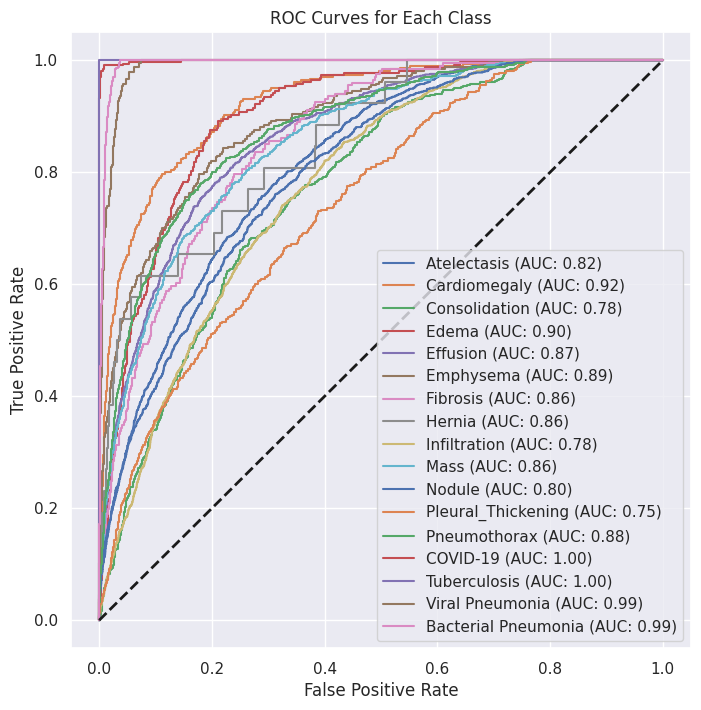

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_trues and y_preds are already defined
# class_labels should be a list of class names

# Plot ROC curves for each class
fig, c_ax = plt.subplots(1, 1, figsize=(8, 8))
for (idx, c_label) in enumerate(class_labels):
    fpr, tpr, thresholds = roc_curve(y_trues[:, idx], y_preds[:, idx])
    auc_score = auc(fpr, tpr)
    c_ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')

# Plotting the diagonal line
c_ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_title('ROC Curves for Each Class')
c_ax.legend(loc='best')

# Save the figure
fig.savefig('ROC Curves.png')
plt.show()

Micro-Average ROC AUC Score: 0.9063


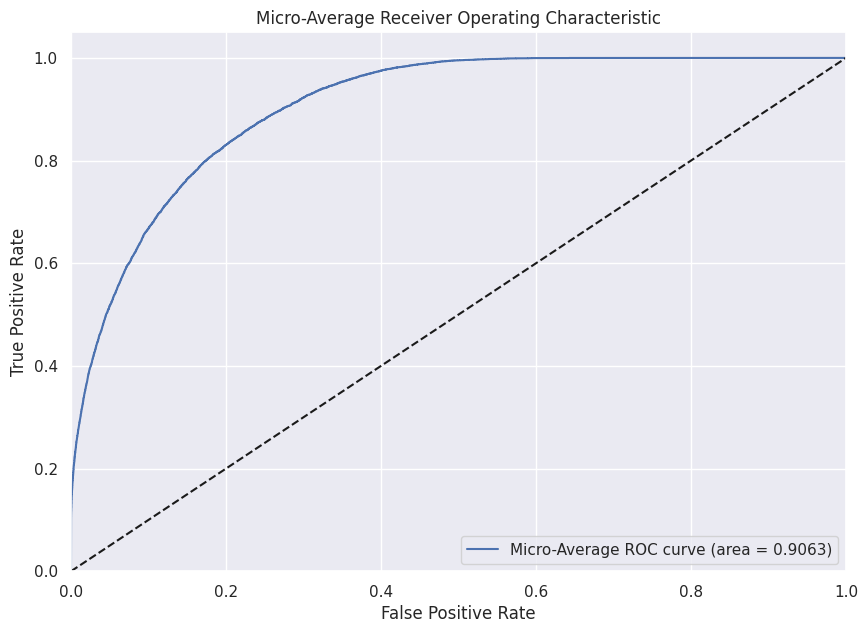

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute the ROC AUC score (micro-average)
roc_auc_micro = roc_auc_score(y_trues, y_preds, average='micro')
print(f"Micro-Average ROC AUC Score: {roc_auc_micro:.4f}")

# Compute the ROC curve (micro-average)
fpr, tpr, _ = roc_curve(y_trues.ravel(), y_preds.ravel())

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Micro-Average ROC curve (area = {roc_auc_micro:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the figure
plt.savefig('Micro-Average-ROC.png', bbox_inches='tight')

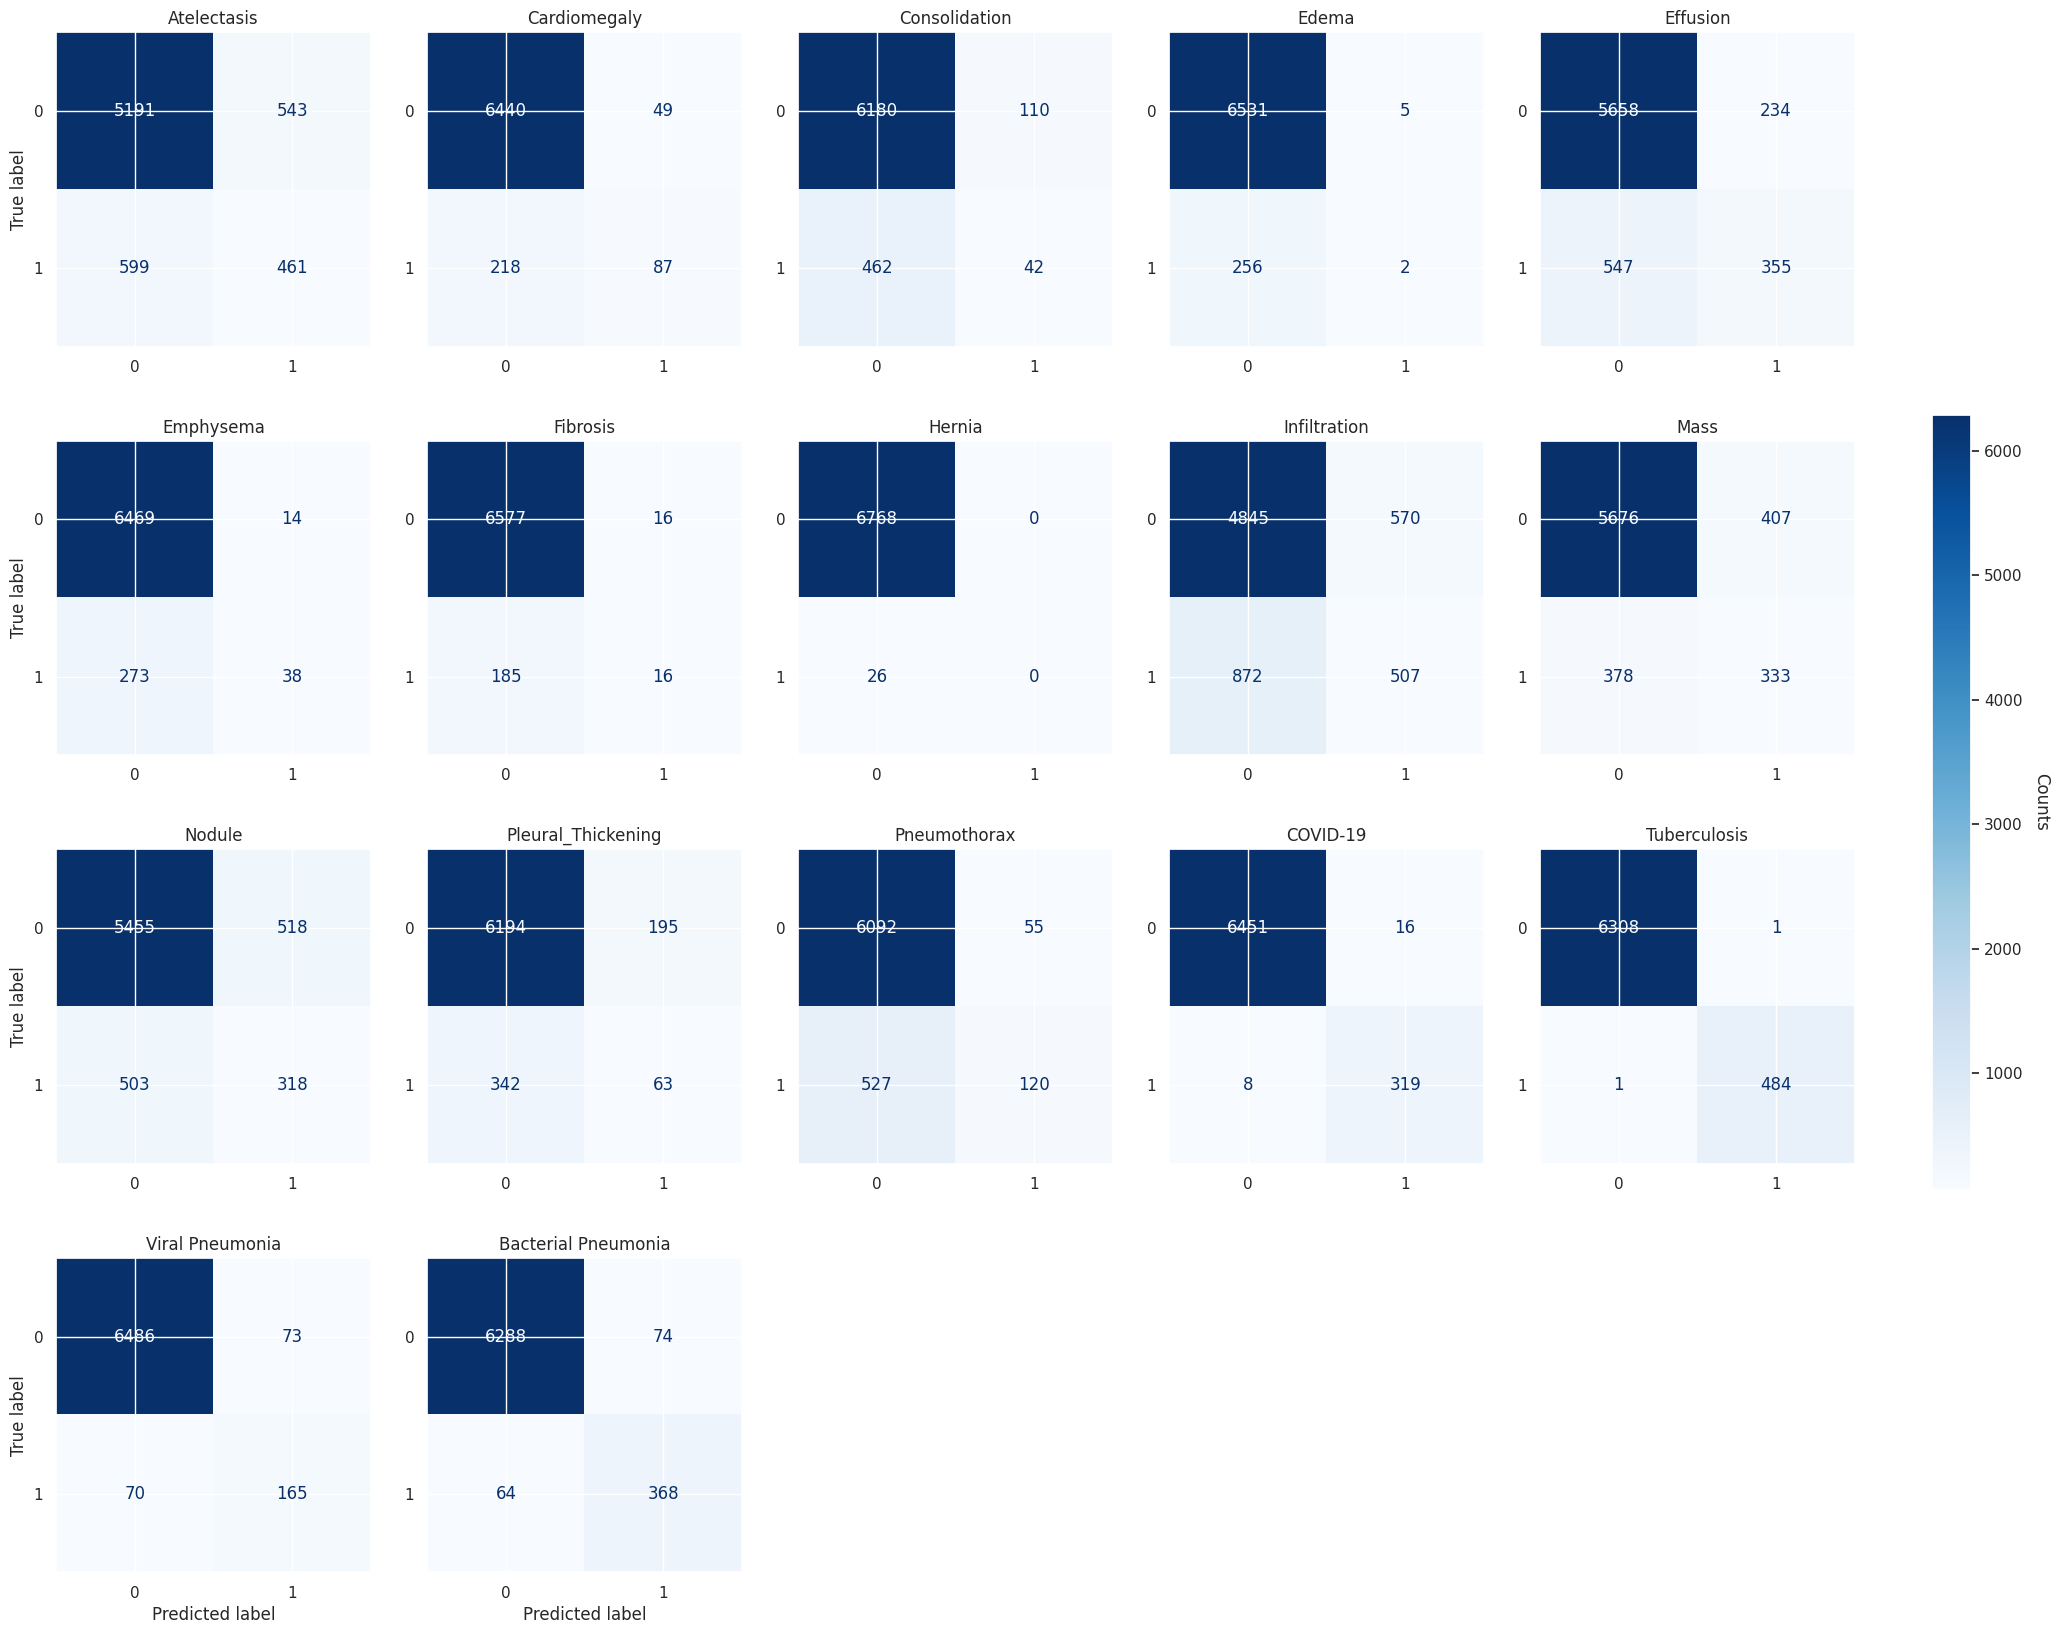

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Assume `y_preds`, `y_trues`, and `labels` are defined
y_pred = (y_preds > 0.4).astype(int)
y_true = y_trues

# Calculate the confusion matrix for each label
cm = multilabel_confusion_matrix(y_true, y_pred)

# Set the figure size and create subplots
rows = 4  # Number of rows for the plot grid
cols = 5  # Number of columns for the plot grid (4x5=20 > 17, leaving extra space)
f, axes = plt.subplots(rows, cols, figsize=(25, 20))  # Adjusted size for 17 plots
axes = axes.ravel()

# Loop through each class label
for i in range(len(labels)):
    # Create the confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred[:, i]),
                                  display_labels=[0, 1])  # Assuming binary labels (0, 1)
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')
    disp.ax_.set_title(labels[i])

    # Adjust axis labels
    if i < (rows - 1) * cols:
        disp.ax_.set_xlabel('')
    if i % cols != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()  # Remove the individual colorbar

# Turn off unused axes
for j in range(len(labels), rows * cols):
    f.delaxes(axes[j])

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.10, hspace=0.3)

# Add a single, shared colorbar
cbar = f.colorbar(disp.im_, ax=axes, location='right', fraction=0.02, pad=0.04)
cbar.ax.set_ylabel('Counts', rotation=270, labelpad=20)

# Save the plot as a PNG file
plt.savefig('confusion_matrix_17_diseases.png', bbox_inches='tight')
plt.show()

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
y_pred_classes = np.where(y_preds > 0.4, 1, 0)  # Assuming binary classification

In [36]:
# Initialize dictionaries to hold scores per class
precision_scores = {}
recall_scores = {}
f1_scores = {}
accuracy_scores = {}

# Extract class labels from the dataframe columns
class_labels = test_df[labels].columns

for i, label in enumerate(class_labels):
    precision = precision_score(y_trues[:, i], y_pred_classes[:, i])
    recall = recall_score(y_trues[:, i], y_pred_classes[:, i])
    f1 = f1_score(y_trues[:, i], y_pred_classes[:, i])
    accuracy = accuracy_score(y_trues[:, i], y_pred_classes[:, i])
    
    # Store the scores
    precision_scores[label] = precision
    recall_scores[label] = recall
    f1_scores[label] = f1
    accuracy_scores[label] = accuracy

# Print the metrics for each class
for label in class_labels:
    print(f"{label} - Precision: {precision_scores[label]:.4f}, Recall: {recall_scores[label]:.4f}, F1 Score: {f1_scores[label]:.4f}, Accuracy: {accuracy_scores[label]:.4f}")

# Calculate and print the average accuracy across all classes
average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)
print(f"\nAverage Accuracy across all classes: {average_accuracy:.4f}")

Atelectasis - Precision: 0.4592, Recall: 0.4349, F1 Score: 0.4467, Accuracy: 0.8319
Cardiomegaly - Precision: 0.6397, Recall: 0.2852, F1 Score: 0.3946, Accuracy: 0.9607
Consolidation - Precision: 0.2763, Recall: 0.0833, F1 Score: 0.1280, Accuracy: 0.9158
Edema - Precision: 0.2857, Recall: 0.0078, F1 Score: 0.0151, Accuracy: 0.9616
Effusion - Precision: 0.6027, Recall: 0.3936, F1 Score: 0.4762, Accuracy: 0.8850
Emphysema - Precision: 0.7308, Recall: 0.1222, F1 Score: 0.2094, Accuracy: 0.9578
Fibrosis - Precision: 0.5000, Recall: 0.0796, F1 Score: 0.1373, Accuracy: 0.9704
Hernia - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000, Accuracy: 0.9962
Infiltration - Precision: 0.4708, Recall: 0.3677, F1 Score: 0.4129, Accuracy: 0.7878
Mass - Precision: 0.4500, Recall: 0.4684, F1 Score: 0.4590, Accuracy: 0.8845
Nodule - Precision: 0.3804, Recall: 0.3873, F1 Score: 0.3838, Accuracy: 0.8497
Pleural_Thickening - Precision: 0.2442, Recall: 0.1556, F1 Score: 0.1900, Accuracy: 0.9210
Pneumothorax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming precision_scores, recall_scores, f1_scores, and accuracy_scores are already calculated

# Extract class labels from the dictionary keys
class_labels = list(precision_scores.keys())

# Combine all metrics into a single matrix
metrics_matrix = np.array([
    list(precision_scores.values()),
    list(recall_scores.values()),
    list(f1_scores.values()),
    list(accuracy_scores.values())
])

# Define the metric names
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Plotting the metrics in a matrix-style grid
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(metrics_matrix, cmap='Blues')

# Add color bar
plt.colorbar(cax)

# Set axis labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(metric_names)))

# Label the axes with class names and metric names
ax.set_xticklabels(class_labels, rotation=45, ha="left")
ax.set_yticklabels(metric_names)

# Loop over data dimensions and create text annotations
for i in range(len(metric_names)):
    for j in range(len(class_labels)):
        ax.text(j, i, f'{metrics_matrix[i, j]:.2f}', ha='center', va='center', color='black')

# Set titles and layout
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Metrics per Class')
fig.savefig('Metrics per Class.png')
plt.show()

In [ ]:
avg_precision = np.mean(list(precision_scores.values()))
avg_recall = np.mean(list(recall_scores.values()))
avg_f1 = np.mean(list(f1_scores.values()))
avg_accuracy = np.mean(list(accuracy_scores.values()))

print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

In [ ]:
#  *********************************** Using Thresolding ************************************
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

# Path to the images directory
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"

# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    # Normalize the image by scaling to [0, 1]
    img = img / 255.0
    
    # Subtract the mean and divide by the standard deviation (ImageNet values)
    img = (img - mean) / std
    
    return img

# Function to predict diseases for an image
def predict_disease_from_id(image_id, test_data):
    # Find the image row from the dataset using the image_id
    image_row = test_data[test_data['Image Index'] == image_id]
    
    # Check if the image exists in the dataset
    if image_row.empty:
        print(f"Image with ID {image_id} not found in the dataset.")
        return
    
    # Debugging: print the row to understand the data format
    print(f"Row for image {image_id}:")
    print(image_row)
    
    # Extract the ground truth (disease labels) from the row based on the 14 labels
    ground_truth = image_row[labels].values.astype(int).flatten()  # Flatten to make it 1D
    
    # Ensure ground_truth has the expected shape
    print(f"Ground truth array: {ground_truth}")
    
    # Check if ground_truth length matches the number of labels (14)
    if len(ground_truth) != len(labels):
        print(f"Mismatch in ground truth length. Expected {len(labels)} but got {len(ground_truth)}.")
        return

    # Load the image
    img_path = f"{IMAGE_DIR}/{image_id}"
    img = cv2.imread(img_path)
    
    # Check if the image exists
    if img is None:
        print(f"Image file {image_id} not found.")
        return
    
    # Resize image to match the model input size (224x224)
    img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
    
    # Preprocess the image using the custom preprocessing function
    img_preprocessed = preprocess_image(img_resized)
    
    # Predict the disease labels
    predictions = model.predict(np.expand_dims(img_preprocessed, axis=0))
    
    # Print the raw predictions (probabilities)
    print(f"Raw Predictions: {predictions}")
    
    # Define a threshold for classification (e.g., 0.5)
    threshold = 0.16

    # Create a list to store the diseases with their corresponding probabilities
    predicted_diseases = []
    
    # Iterate through all predicted probabilities
    for i, prob in enumerate(predictions[0]):
        if prob > threshold:  # If the probability is above the threshold
            predicted_diseases.append((labels[i], prob))  # Store the disease and its probability

    # Sort the diseases based on probability (highest first)
    predicted_diseases.sort(key=lambda x: x[1], reverse=True)
    
    # Extract the diseases and their probabilities
    predicted_diseases_names = [disease[0] for disease in predicted_diseases]
    predicted_diseases_probs = [disease[1] for disease in predicted_diseases]

    # Output the ground truth and predicted diseases with their probabilities
    ground_truth_diseases = [labels[i] for i, label in enumerate(ground_truth) if label == 1]

    print(f"Ground Truth: {', '.join(ground_truth_diseases) if ground_truth_diseases else 'No disease'}")
    print(f"Predicted Diseases: {', '.join(predicted_diseases_names) if predicted_diseases_names else 'No disease'}")
    
    # Optionally print the predicted diseases with their probabilities
    for disease, prob in zip(predicted_diseases_names, predicted_diseases_probs):
        print(f"Predicted {disease} with probability: {prob:.4f}")

# Example usage
image_id = "00018455_001.png"  # Replace with the actual image ID from your test dataset
predict_disease_from_id(image_id, test_df)

In [ ]:
#******************************************** Without Thresolding ************************************
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd

# Path to the images directory
IMAGE_DIR = "/kaggle/input/images/cleanimagefolder"

# Define the mean and standard deviation values for normalization using ImageNet values
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define a custom preprocessing function to normalize the image
def preprocess_image(img):
    # Normalize the image by scaling to [0, 1]
    img = img / 255.0
    
    # Subtract the mean and divide by the standard deviation (ImageNet values)
    img = (img - mean) / std
    
    return img

# Function to predict diseases for a single image
def predict_disease_from_id(image_id, test_data):
    # Find the image row from the dataset using the image_id
    image_row = test_data[test_data['Image Index'] == image_id]
    
    # Check if the image exists in the dataset
    if image_row.empty:
        print(f"Image with ID {image_id} not found in the dataset.")
        return
    
    # Extract the ground truth (disease labels) from the row based on the 14 labels
    ground_truth = image_row[labels].values.astype(int).flatten()  # Flatten to make it 1D
    
    # Ensure ground_truth has the expected shape
    print(f"Ground truth array: {ground_truth}")
    
    # Check if ground_truth length matches the number of labels (14)
    if len(ground_truth) != len(labels):
        print(f"Mismatch in ground truth length. Expected {len(labels)} but got {len(ground_truth)}.")
        return

    # Load the image
    img_path = f"{IMAGE_DIR}/{image_id}"
    img = cv2.imread(img_path)
    
    # Check if the image exists
    if img is None:
        print(f"Image file {image_id} not found.")
        return
    
    # Resize image to match the model input size (224x224)
    img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
    
    # Preprocess the image using the custom preprocessing function
    img_preprocessed = preprocess_image(img_resized)
    
    # Predict the disease labels
    predictions = model.predict(np.expand_dims(img_preprocessed, axis=0))  # Make prediction for one image
    
    # Print the raw predictions (probabilities)
    print(f"Raw Predictions: {predictions}")
    
    # Create a list to store the diseases with their corresponding probabilities
    predicted_diseases = []
    
    # Iterate through all predicted probabilities
    for i, prob in enumerate(predictions[0]):
        predicted_diseases.append((labels[i], prob))  # Store the disease and its probability

    # Sort the diseases based on probability (highest first)
    predicted_diseases.sort(key=lambda x: x[1], reverse=True)
    
    # Extract the diseases and their probabilities
    predicted_diseases_names = [disease[0] for disease in predicted_diseases]
    predicted_diseases_probs = [disease[1] for disease in predicted_diseases]

    # Output the ground truth and predicted diseases with their probabilities
    ground_truth_diseases = [labels[i] for i, label in enumerate(ground_truth) if label == 1]

    print(f"Ground Truth: {', '.join(ground_truth_diseases) if ground_truth_diseases else 'No disease'}")
    print(f"Predicted Diseases: {', '.join(predicted_diseases_names) if predicted_diseases_names else 'No disease'}")
    
    # Optionally print the predicted diseases with their probabilities
    for disease, prob in zip(predicted_diseases_names, predicted_diseases_probs):
        print(f"Predicted {disease} with probability: {prob:.4f}")

# Example usage
image_id = "00018455_001.png"  # Replace with the actual image ID from your test dataset
predict_disease_from_id(image_id, test_df)

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, img_array, class_idx, layer_name="conv5_block16_concat"):
    """
    Generate the GradCAM heatmap for a specific class index and layer.
    """
    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        tape.watch(img_array)
        conv_output, predictions = grad_model(img_array)
        class_output = predictions[:, class_idx]
    
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    heatmap = tf.reduce_sum(tf.multiply(conv_output, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize

    return heatmap.numpy()

def predict_and_generate_gradcam(image_id, test_data, top_n=14):
    image_row = test_data[test_data['Image Index'] == image_id]
    if image_row.empty:
        print(f"Image with ID {image_id} not found.")
        return

    ground_truth = image_row[labels].values.astype(int).flatten()
    img_path = f"{IMAGE_DIR}/{image_id}"
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image file {image_id} not found.")
        return

    img_resized = cv2.resize(img, (224, 224))
    img_preprocessed = preprocess_image(img_resized)
    predictions = model.predict(tf.expand_dims(img_preprocessed, axis=0))

    # Get all the disease predictions
    probs = predictions[0]
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]

    # Print predicted diseases with their probabilities
    print("Predicted Diseases and Probabilities:")
    for i in range(top_n):
        print(f"{sorted_labels[i]}: {sorted_probs[i] * 100:.2f}%")

    # Plot the images and Grad-CAM overlays in a 2x7 grid
    plt.figure(figsize=(20, 14))  # Adjust the figure size for 14 plots
    plt.subplot(2, 8, 1)  # First subplot
    plt.imshow(img_resized)
    plt.axis('off')
    plt.title("Original Image")

    for i in range(top_n):
        gradcam = grad_cam(model, tf.expand_dims(img_preprocessed, axis=0), sorted_indices[i])
        gradcam_resized = cv2.resize(gradcam, (224, 224), interpolation=cv2.INTER_LINEAR)
        overlay = np.uint8(255 * gradcam_resized)
        heatmap = cv2.applyColorMap(overlay, cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255.0

        img_resized_float = np.float32(img_resized) / 255.0
        blended_img = 0.5 * img_resized_float + 0.5 * heatmap

        plt.subplot(2, 8, i + 2)  # Create subplots in a 2x7 grid
        plt.imshow(blended_img)
        plt.axis('off')
        plt.title(f"{sorted_labels[i]}: {sorted_probs[i] * 100:.2f}%")

    plt.tight_layout()  # Adjust layout to avoid overlapping
    plt.show()

# Example usage
predict_and_generate_gradcam(image_id="00018455_001.png", test_data=test_df, top_n=7)